In [1]:
# （必須）モジュールのインポート
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except:
    pass

In [2]:
# （必須）カレントディレクトリの変更（自分の作業フォルダのパスをコピーして入力する）
os.chdir(r"C:\Users\parar\OneDrive\sport_data")

- **このページの.ipynbファイル**：[7_tracking.ipynb](https://drive.google.com/uc?export=download&id=1APledOhIbxfYzWWb3iIBLCmC9DQIRDMv)

- **最新の内容が表示されない場合は強制リロードして下さい．**
    - Windows: `Ctrl+F5`
    - Mac: `Command+R` or `Command + Shift + R`


# トラッキングデータの解析

## データセット

### Pettersenデータセット

Pettersenデータセットはサッカーのトラッキングデータをまとめたデータセットである．
試合数は3試合と少ないが，2022年時点で一般公開されている数少ない（唯一の？）サッカートラッキングデータである．
データセットの内容は以下の論文にまとめられている：

- S. A. Pettersen, D. Johansen, H. Johansen, V. Berg-Johansen, V. R. Gaddam, A. Mortensen, R. Langseth, C. Griwodz, H. K. Stensland, and P. Halvorsen: Proceedings of the 5th ACM Multimedia Systems Conference, 2014, pp. 18–23. https://doi.org/10.1145/2557642.2563677
- [論文PDFはこちら](https://www.researchgate.net/publication/260983291_Soccer_Video_and_Player_Position_Dataset)

また，全データは以下のウェブサイトからダウンロード可能である：
- [Alfheim - Soccer video and player position dataset](https://datasets.simula.no/alfheim/)

### データセットの内容

本データセットはノルウェーのAlfheimスタジアムにおいて取得されている．
対象となる試合はAlfheimスタジアムを本拠地とするTromsø ILの3試合である．
データセットには試合映像とセンサーによって取得された位置座標のデータ（トラッキングデータ）が含まれているが，トラッキングデータの取得対象はTromsø ILの選手のみである．
また，選手のプライバシー保護のため，トラッキングデータから選手の個人情報は除去されている．

| 日時 | 対戦カード | データの種類 | 備考 |
| ---- | ---- | ---- | ---- |
| 2013-11-03 | Tromsø IL - Strømsgodset | トラッキングデータ<br>試合映像 |  |
| 2013-11-07 | Tromsø IL - Anzhi | トラッキングデータ<br>試合映像 |  |
| 2013-11-28 | Tromsø IL - Tottenham Hotspurs | トラッキングデータ<br>試合映像<br>ボールの座標データ | 前半40分のみ<br>ボール座標は手作業で取得 |

トラッキングデータには以下の2種類の形式が用意されている：
- raw data：センサから取得した生データ
- interpolated data：時間単位を0.05秒に統一したデータ

トラッキングデータに含まれる変数は下表の通りである．

| 変数 | データ型 | 内容 | 例 |
| ---- | ---- | ---- | ---- |
| time | string | 時刻 | 18:01:09.05 |
| id | int | 選手の識別ID | Homeチームのみ．交代選手は新たなID． |
| $x$ | float | $x$座標 | 26.573 m |
| $y$ | float | $y$座標 | 29.436 m |
| heading | float | 選手の向き（センサから取得） | $y$軸からの角度（rad） |
| direction | float | 選手の移動方向 |  $y$軸からの角度（rad） |
| energy | float | エネルギー消費量 | 単位は不明 |
| speed | float | 選手の速さ | 0.968 m/s |
| total_distance | float | 試合開始からの移動距離 | 255.584 m |

**利用規約**

- 選手個人の再識別は禁止
- 選手・クラブのパフォーマンスプロファイルの作成は禁止
- 非営利的な研究目的での使用に限定

**トラッキングシステム**


- ZXYシステム
    - ZXY Sport Tracking system by ChyronHego (Trondheim, Norway)
- センサーベルト
    - 選手の胸下に装着
    - 重さ10g
    - 加速度センサ，ジャイロセンサ，心拍計，コンパスを搭載
    - 心拍データはデータセットから除外
    - レシーバーをスタジアム内に設置

**座標系**

- 原点：フィールドの左下
- $x$軸：長軸方向（$0 \le x \le 105$）
- $y$軸：短軸方向（$0 \le x \le 68$）
- 単位はm

**時間の解像度**
- 1フレーム=0.05秒
- フレームレートは20fps
- ※ interporated dataを用いた場合

## データの前処理

ここでは，Tromsø IL vs Strømsgodsetの前半のトラッキングデータを解析対象とする．
まずは以下からトラッキングデータのcsvファイルをダウンロードし，作業フォルダ（例えばOneDrive/sport_data/7_tracking）に移動しておく：
- https://datasets.simula.no/downloads/alfheim/2013-11-03/zxy/2013-11-03_tromso_stromsgodset_first.csv

### データの加工・整形

**データの読み込み**

ダウンロードしたcsvファイルを`df`という名前でDataFrameに読み込む．
その際に列ラベル（`columns`）を指定しておく．

In [42]:
df = pd.read_csv('./7_tracking/2013-11-03_tromso_stromsgodset_first.csv',\
                 header=None, encoding='utf-8',\
                 names=['time','id','x','y','heading','direction','energy','speed','total_distance'])
df.head(2)

**時刻・選手ID・位置座標の抽出**

読み込んだデータには向き（'heading', 'direction'）や速さ（'speed'）などの列も含まれているが，以下では時刻（'time'），選手ID（'id'），位置座標（'x', 'y'）の情報だけを用いるので，これらを抽出する．

In [43]:
df = df[['time', 'id', 'x', 'y']]
df.head(2)

**DataFrameのソート**

次に，`sort_values`メソッドを用いて，'time'列，'id'列をキーにして`df`をソートする．これにより`df`の行方向の並びが時間順となり，同一時刻の場合は選手ID順となる．

In [44]:
# time列, id列でソート
df = df.sort_values(['time', 'id']).reset_index(drop=1)
df.head(2)

**日時の変換**

'time'列には試合が行われた年月日および時刻が文字列として保存されている．
このうち，前半の年月日の情報は不要なので，`str.split`メソッドを用いて年月日と時刻を切り離す．

In [45]:
tmp = df['time'].str.split(' ', expand=True)
tmp.head(2)

,0,1
0,2013-11-03,18:01:09
1,2013-11-03,18:01:09


時刻の情報は`18:01:09`という形式の文字列である．
これを以下の手順に従い試合開始からの経過時間に変換する：
- 時・分・秒を`str.split`メソッドによって切り離す
- 分と秒の情報だけを取り出し，単位を秒に変換する
- `df`の第0行からの経過時間に変換し，`df`の'time'列に追加する

In [46]:
# 経過時間（秒）に変換
times = tmp[1].str.split(':', expand=True).astype(float)
sec = times[1]*60 + times[2]
df['time'] = sec - sec.iloc[0]

df.head(2)

**選手別の座標に変換**

各選手の$x$座標と$y$座標を格納した以下のようなDataFrame，`df_x`，`df_y`を作成する：

- 行ラベル（`index`）：フレーム番号
    - 1行=1フレーム=0.05秒
- 列ラベル（`columns`）：選手ID
- $(i, j)$ 成分：ある時刻における特定の選手の$x, y$座標

In [47]:
U = df['id'].unique()  # 選手ID
T = np.arange(0, df['time'].max()+0.05, 0.05)  # 0.05秒刻みの経過時間
df_x = DataFrame({'t': T})  # x座標
df_y = DataFrame({'t': T})  # y座標

for u in U:
    df_u = df.loc[df['id']==u]  # 選手uだけ抽出
    df_u.index = (df_u['time']/0.05).round().astype(int)  # インデックスをフレーム番号に

    df_x[u], df_y[u] = np.nan, np.nan
    df_x.loc[df_u.index, u] = df_u['x']
    df_y.loc[df_u.index, u] = df_u['y']

df_x, df_y = df_x[U], df_y[U]  # 't'列を除去

In [8]:
df_x.head(2)

,1,2,5,7,8,9,10,12,13,14,15,6,11,3
0,53.1384,26.572793,35.550286,41.586068,28.506505,32.2538,45.2474,74.5904,21.028585,28.530169,50.083661,NaN,NaN,NaN
1,53.1384,26.608666,35.544886,41.571572,28.537430,32.2538,45.2474,74.5904,21.069608,28.527878,50.105006,NaN,NaN,NaN


In [9]:
df_y.head(2)

,1,2,5,7,8,9,10,12,13,14,15,6,11,3
0,44.062,29.435691,30.268062,38.675045,39.611611,12.7243,14.4618,71.048,17.623663,17.596749,25.779104,NaN,NaN,NaN
1,44.062,29.466860,30.299452,38.662632,39.567760,12.7243,14.4618,71.048,17.623336,17.561468,25.722345,NaN,NaN,NaN


### 不要な選手の除去

`df_x`，`df_y`には以下の選手の座標が含まれている：

In [48]:
df_x.columns

Index([1, 2, 5, 7, 8, 9, 10, 12, 13, 14, 15, 6, 11, 3], dtype='object')

この中には，実際に試合に出場した選手の他に審判などの位置座標も含まれている．
まずはこれら不要なデータを特定するため，選手IDごとに位置座標を全てプロットする．

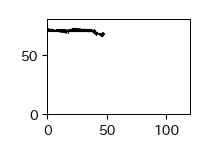

In [57]:
u = 6
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(df_x[u], df_y[u], '.', ms=0.1)
ax.set_xlim(0, 120); ax.set_ylim(0, 80)
ax.set_aspect('equal')

位置座標をプロットした結果を踏まえると，以下の10人が試合に出場した選手と考えられる：
```
1, 2, 5, 7, 8, 9, 10, 13, 14, 15
```
`df_x`，`df_y`からこれらの選手のデータだけ抽出する．

In [50]:
df_x2 = df_x[[1, 2, 5, 7, 8, 9, 10, 13, 14, 15]]
df_y2 = df_y[[1, 2, 5, 7, 8, 9, 10, 13, 14, 15]]

In [51]:
df_x2.head(2)

,1,2,5,7,8,9,10,13,14,15
0,53.1384,26.572793,35.550286,41.586068,28.506505,32.2538,45.2474,21.028585,28.530169,50.083661
1,53.1384,26.608666,35.544886,41.571572,28.537430,32.2538,45.2474,21.069608,28.527878,50.105006


In [52]:
df_y2.head(2)

,1,2,5,7,8,9,10,13,14,15
0,44.062,29.435691,30.268062,38.675045,39.611611,12.7243,14.4618,17.623663,17.596749,25.779104
1,44.062,29.466860,30.299452,38.662632,39.567760,12.7243,14.4618,17.623336,17.561468,25.722345


### データの保存

In [53]:
df_x2.to_csv('./7_tracking/x_1st.csv', header=True, index=True, encoding='utf-8')
df_y2.to_csv('./7_tracking/y_1st.csv', header=True, index=True, encoding='utf-8')

### 発展問題

- トラッキングデータの前処理を行う関数を作成せよ
- この関数を用いて後半のデータや他の試合のデータの前処理を行え

## トラッキングデータ解析の基本

### データの読み込み

改めて，作成したデータを`X`，`Y`というDataFrameに読み込む．

In [66]:
X = pd.read_csv('./7_tracking/x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./7_tracking/y_1st.csv', encoding='utf-8', index_col=0)

### データの扱い方

**データの構造**

DataFrame`X`，`Y`は以下のような構造になっている：
- 行ラベル（`index`）：フレーム番号
    - 1行=1フレーム=0.05秒
- 列ラベル（`columns`）：選手ID
- $(i, j)$ 成分：ある時刻における特定の選手の$x, y$座標

In [68]:
X.head(2)

,1,2,5,7,8,9,10,13,14,15
0,53.1384,26.572793,35.550286,41.586068,28.506505,32.2538,45.2474,21.028585,28.530169,50.083661
1,53.1384,26.608666,35.544886,41.571572,28.537430,32.2538,45.2474,21.069608,28.527878,50.105006


**特定の時間帯の抽出**

`X`，`Y`の行ラベル（`index`）はフレーム番号に等しい．
1フレーム=0.05秒なので，試合開始 $t$ 秒後の座標は$20\times t$ 行目を参照すれば良い．
よって，`X`，`Y`から`loc`属性を用いて条件付き抽出すれば，特定の時刻のデータだけ抜き出せる．
例えば，10秒〜20秒の時間帯だけ抽出するには，行ラベル（`index`）が200から400までの行を条件付き抽出すればよい．

In [69]:
X.loc[200:400]

,1,2,5,7,8,9,10,13,14,15
200,54.117386,24.795745,37.752606,41.883054,27.184537,32.939955,43.508690,21.114114,27.968200,53.166243
201,54.273830,24.815915,37.778375,41.876645,27.183900,32.941336,43.543693,21.073405,27.968200,53.313702
202,54.433934,24.836619,37.805612,41.871515,27.184705,32.942200,43.581172,21.042482,27.941973,53.467094
203,54.597557,24.857586,37.834853,NaN,27.186795,32.942164,43.620530,21.021235,27.790001,53.626254
204,54.764830,24.878788,37.866295,41.865941,27.190085,32.941225,43.661059,21.009488,27.794145,53.791047
...,...,...,...,...,...,...,...,...,...,...
396,52.730470,13.496498,27.311687,26.922030,12.059442,19.890845,33.062287,14.049493,22.356699,55.207211
397,52.852482,13.703655,27.403945,27.126697,12.069498,20.134911,33.228296,14.204214,22.506924,55.274194
398,52.977519,13.915977,27.493247,27.336069,12.083855,20.380964,33.396046,14.359052,22.656021,55.339214
399,53.105407,14.133198,27.580294,27.549362,12.102853,20.628587,33.565289,14.513308,22.804447,55.402200


フレーム番号を秒単位に直すのが面倒な場合は，以下のように`index`を秒単位に変換した`T`というSeriesを作っておき，これを用いて条件付き抽出すればよい．

In [70]:
T = X.index * 0.05
X.loc[(T >= 10) & (T <= 20)]

,1,2,5,7,8,9,10,13,14,15
200,54.117386,24.795745,37.752606,41.883054,27.184537,32.939955,43.508690,21.114114,27.968200,53.166243
201,54.273830,24.815915,37.778375,41.876645,27.183900,32.941336,43.543693,21.073405,27.968200,53.313702
202,54.433934,24.836619,37.805612,41.871515,27.184705,32.942200,43.581172,21.042482,27.941973,53.467094
203,54.597557,24.857586,37.834853,NaN,27.186795,32.942164,43.620530,21.021235,27.790001,53.626254
204,54.764830,24.878788,37.866295,41.865941,27.190085,32.941225,43.661059,21.009488,27.794145,53.791047
...,...,...,...,...,...,...,...,...,...,...
396,52.730470,13.496498,27.311687,26.922030,12.059442,19.890845,33.062287,14.049493,22.356699,55.207211
397,52.852482,13.703655,27.403945,27.126697,12.069498,20.134911,33.228296,14.204214,22.506924,55.274194
398,52.977519,13.915977,27.493247,27.336069,12.083855,20.380964,33.396046,14.359052,22.656021,55.339214
399,53.105407,14.133198,27.580294,27.549362,12.102853,20.628587,33.565289,14.513308,22.804447,55.402200


**スナップショットの描画**

以上を踏まえて，試合中の特定の時刻のスナップショットを描いてみよう．

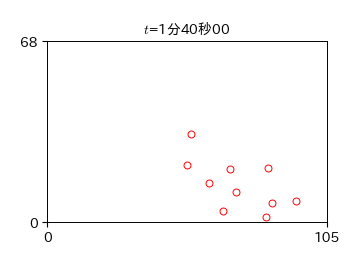

In [33]:
fig, ax = plt.subplots()

# フレーム番号
i=2000

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 時刻の表示
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s分%s秒%s' % (m, s, ss), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 重心と標準偏差の計算

集団の動きを解析する際に，チーム全体のおおまかな位置と広がりを把握することは非常に重要である．
これらの量の定義の仕方は色々と考えられるが，以下では重心と慣性半径を計算する．

**チームの重心**

チームの重心は，メンバー全員の平均位置を表す量で，以下のように定義される：
$$
X_{c}(i) = \frac{1}{N} \sum_{u=1}^{N} X_{u}(i), \\[10pt]
Y_{c}(i) = \frac{1}{N} \sum_{u=1}^{N} Y_{u}(i), \\[10pt]
$$
ここで，$X_{u}(i),\ Y_{u}(i)$は第$i$フレームの選手$u$の$x,\ y$座標である．
これは，全選手の$x,\ y$座標の平均値を求めれば良いので，以下のように計算できる：

In [74]:
Xc = X.mean(axis=1)
Yc = Y.mean(axis=1)

**チームの慣性半径**

次に，チームの広がりを表す量として，慣性半径を導入する．
これは，重心から各選手までの距離の標準偏差として以下のように定義される：

$$
    R(i) = \sqrt{ \frac{1}{N} \sum_{u=1}^{N} [(X_{u}(i) - X_{c}(i))^{2} + (Y_{u}(i) - Y_{c}(i))^{2}] }
$$

In [59]:
R = np.sqrt(X.var(ddof=0, axis=1) + Y.var(ddof=0, axis=1))

**重心と慣性半径の描画**

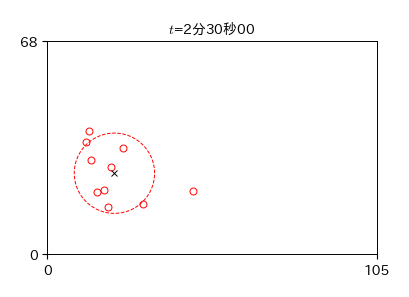

In [80]:
fig, ax = plt.subplots(figsize=(4, 4))

# フレーム番号
i=3000

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 重心と標準偏差の描画
xc, yc = Xc.loc[i], Yc.loc[i]
r = R.loc[i]
ax.plot(xc, yc, 'kx')
theta = np.linspace(0, 2*np.pi)
ax.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), 'r--')

# 時刻の表示
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s分%s秒%s' % (m, s, ss), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 速度と秩序変数の計算

**速度**

次に，位置座標から速度を求めてみよう．
速度の$x,\ y$成分を$V_{x},\ V_{y}$とすると，これらは以下のように表される：

$$
V_{x}(i) = \frac{X(i+n) - X(i)}{0.05n},\\[10pt]
V_{y}(i) = \frac{Y(i+n) - Y(i)}{0.05n}
$$

ここで，$X(i),\ Y(i)$は第$i$フレームの$x, y$座標を表し，$n$はフレームの増分である．
また，座標の差分を$0.05$で割ることで単位を[m/frame]から[m/s]に変換している．
以下では，$n=20$として，20フレーム（=1秒間）の平均速度を求める．
実装には`diff`メソッドを用いて`n`フレーム前との差分を計算すれば良い．

In [75]:
n = 20
Vx, Vy = X.diff(n)/(0.05*n), Y.diff(n)/(0.05*n)  # nフレーム（0.05n秒）前との差を取る

In [76]:
Vx.tail(2)

,1,2,5,7,8,9,10,13,14,15
56659,NaN,-0.493856,0.566164,0.517217,1.563518,-0.88135,-0.731252,0.272561,0.252315,0.205901
56660,NaN,-0.496038,0.554768,0.508619,1.522897,-0.83057,-0.643381,0.326210,0.243992,0.178878


**秩序変数**

やや高度ではあるが，以下で定義される**秩序変数（Order Parameter）**という量を計算してみよう：

$$
\phi(i) = \left| \frac{1}{N} \sum_{u=1}^{N} \frac{\vec{v}_{u}(i)}{|\vec{v}_{u}(i)|} \right|
$$

秩序変数は，集団の向きの揃い具合を表す量で，統計物理学の分野でよく用いられる．
その定義域は$0\le\phi(t)\le 1$であり，0に近いほど集団の移動方向がバラバラ，1に近いほど揃っていることを意味する．
定義より，秩序変数は速度ベクトルから以下のように計算することができる．

In [77]:
V = np.sqrt(Vx**2 + Vy**2)
OP = np.sqrt(np.sum(Vx/V, axis=1)**2 + np.sum(Vy/V, axis=1)**2) / 10

**速度ベクトルと秩序変数の描画**

速度と秩序変数が計算できたので，これらを描画してみよう．
速度ベクトルの描画には，matplotlibの`quiver`関数を用いて選手の位置を始点とする矢印を描けば良い．
また，秩序変数は時刻の横に文字列として出力する．
フレーム番号を変えると，矢印の向きの揃い具合と連動して秩序変数の値が変化することが分かる．

In [66]:
fig, ax = plt.subplots(figsize=(4,4))

# フレーム番号
i=2000

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 速度ベクトルの描画
vx, vy = Vx.loc[i], Vy.loc[i]
ax.quiver(x, y, vx, vy, color='r', angles='uv', units='xy', scale=0.7, width=0.5)

# 時刻と秩序変数の表示
op = np.round(OP.loc[i], 2)
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s分%s秒%s   $\phi=$%s' % (m, s, ss, op), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 発展問題

- 各選手の走行距離を計算せよ
- 速度から速さ（速度の大きさ）を求め，選手ごとに速さのヒストグラムを求めよ．
- 加速度を計算せよ．

## 支配領域

### ボロノイ領域

2次元平面上に$N$個の個体（**母点**と呼ぶ）が配置されているとき，平面上の各点を「どの母点から最も近いか」という基準で分割する．
このとき，母点$p$から最も近い領域のことを母点$p$の**ボロノイ領域**と呼ぶ．
通常，近さの基準はユークリッド距離によって定める．
下図は，５つの母点に対するボロノイ領域の例である．
この中で，青色で示した領域は母点$p_{4}$から最も近い領域，すなわち母点$p_{4}$のボロノイ領域である．
また，黒丸（●）は各母点のボロノイ領域の交点，点線は境界線を表し，それぞれ**ボロノイ点**，**ボロノイ線**と呼ばれる．

チームスポーツにおいては母点を選手に対応させたボロノイ領域が用いられ，各選手の支配領域と解釈される．
このとき，ボロノイ線は２人の選手からの距離が等しく，ボロノイ点は２人以上の選手からの距離が等しい場所を表す．
よって，守備側チームのボロノイ線とボロノイ点は，攻撃側チームから見ると守備の穴になりやすい場所である．

なお，最近では，「選手$p$から最も近い領域」を「選手$p$から最も速く到達できる領域」に拡張した**優勢領域**が盛んに研究されている．
優勢領域を求めるには，各選手から平面上の全ての位置までの到達時間を計算する必要がある．
この計算に用いられるモデルは**運動モデル**と呼ばれ，運動方程式や機械学習に基づく様々なモデルが提案されている．

In [10]:
from IPython.display import IFrame
IFrame("https://drive.google.com/file/d/1ZcMT3ntGWi4S6ntPbCZXa1dgBMIZPbqH/preview", width=320, height=240)

### ボロノイ領域の計算と描画

Pythonには科学技術計算のためのライブラリであるSciPyが用意されており，Anacondaをインストールすれば標準で使うことができる．
ボロノイ領域の計算には，scipy.spatialモジュールに含まれる`Voronoi`クラスおよび`voronoi_plot_2d`関数を用いる．
まずはこれらを以下のようにインポートする．

In [11]:
from scipy.spatial import Voronoi, voronoi_plot_2d

ボロノイ領域の計算と描画の手順は以下の通りである：
1. ボロノイ領域を計算したい母点の座標を取得する
2. `Voronoi`クラスを用いてオブジェクト（インスタンス）を生成する
    ```python
    vor = Voronoi(xy)
    ```
3. `voronoi_plot_2d`関数を用いてボロノイ領域を描画する
4. 生成したオブジェクト`vor`の属性やメソッドを用いてボロノイ領域の情報を取得する

**母点の生成**

母点の座標はNumPy配列の形で第0列に$x$座標，第1列に$y$座標となるように用意する．
以下ではランダムに5つの母点を生成し`xy`という変数に読み込む．

In [17]:
xy = np.random.rand(5, 2)
xy

array([[0.85251407, 0.44058257],
       [0.32050358, 0.81441878],
       [0.30638828, 0.80512809],
       [0.6617961 , 0.55821873],
       [0.31307777, 0.8776119 ]])

**`Voronoi`クラスによるオブジェクトの生成**

生成した母点の座標`xy`をscipy.spatialからインポートした`Voronoi`クラスに読み込んで`vor`オブジェクトを生成する．

In [18]:
# ボロノイ分割の計算（オブジェクトの生成）
vor = Voronoi(xy)

**ボロノイ領域の描画**

ボロノイ領域の描画には`voronoi_plot_2d`関数を用いる．
引数には生成した`vor`オブジェクトを渡す．

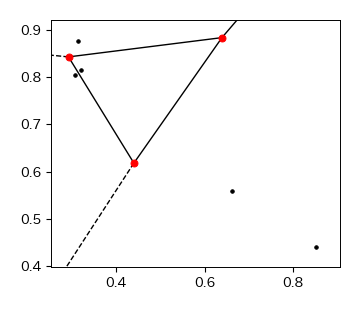

In [19]:
fig = voronoi_plot_2d(vor)

**ボロノイ領域の情報の取得**

生成した`vor`オブジェクトの属性を用いることで，ボロノイ領域の様々な情報を取得できる．

In [20]:
# 母点の座標
vor.points

array([[0.85251407, 0.44058257],
       [0.32050358, 0.81441878],
       [0.30638828, 0.80512809],
       [0.6617961 , 0.55821873],
       [0.31307777, 0.8776119 ]])

In [21]:
# ボロノイ点の座標
vor.vertices

array([[1.726102  , 2.07030872],
       [0.29154419, 0.84304863],
       [0.43976155, 0.61786272],
       [0.63949666, 0.88393644]])

ボロノイ線の情報は`vor.ridge_vertices`により，両端にあるボロノイ点の番号として取得できる．
この番号は，`vor.vertices`のインデックスに対応しており，ボロノイ点が無限遠の場合は-1となる．

In [22]:
# ボロノイ線リスト（vor.verticesのインデックスで表現）
# -1は無限に伸びるボロノイ線のを表す
vor.ridge_vertices

[[-1, 0], [-1, 0], [1, 3], [1, 2], [2, 3], [-1, 1], [0, 3], [-1, 2]]

この例の場合，１つ目のボロノイ線は[-1, 0]なので，0番目のボロノイ点が無限遠まで延びることが分かる．
以下のように無限遠点を除くボロノイ線を取得しておくと便利である．

In [23]:
# ボロノイ線の両端にあるボロノイ点の座標
ind_rv = np.array(vor.ridge_vertices)
ind_rv[~np.any(ind_rv == -1, axis=1)]
vor.vertices[ind_rv]

array([[[0.63949666, 0.88393644],
        [1.726102  , 2.07030872]],

       [[0.63949666, 0.88393644],
        [1.726102  , 2.07030872]],

       [[0.29154419, 0.84304863],
        [0.63949666, 0.88393644]],

       [[0.29154419, 0.84304863],
        [0.43976155, 0.61786272]],

       [[0.43976155, 0.61786272],
        [0.63949666, 0.88393644]],

       [[0.63949666, 0.88393644],
        [0.29154419, 0.84304863]],

       [[1.726102  , 2.07030872],
        [0.63949666, 0.88393644]],

       [[0.63949666, 0.88393644],
        [0.43976155, 0.61786272]]])

ボロノイ線と同様にして，`vor.regions`を用いると，各母点のボロノイ領域を構成するボロノイ点のリストを取得することができる：

In [24]:
# 各ボロノイ領域を構成するボロノイ点のインデックス
vor.regions

[[-1, 0], [], [3, 1, 2], [3, 0, -1, 1], [2, -1, 1], [3, 0, -1, 2]]

### トラッキングデータへの応用

サッカーのトラッキングデータからボロノイ領域を描画するには，特定のフレームにおける選手の座標を取得し，それを母点として`Voronoi`クラスのオブジェクトを生成すれば良い．
ただし，ボロノイ領域の描画に`voronoi_plot_2d`をそのまま用いると，無限に延びるボロノイ線が途中で切れてしまうという問題が発生する．
そこで，ここでは`voronoi_plot_2d`のソースコード（https://github.com/scipy/scipy/blob/v1.8.1/scipy/spatial/_plotutils.py#L151-L265 )を参考に，独自の描画関数`my_voronoi_plot_2d`を以下のように作成する．

In [25]:
def my_voronoi_plot_2d(vor, fig, ax):

    # ボロノイ点の描画
    ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], '.')

    # ボロノイ線の描画
    center = vor.points.mean(axis=0)  # 母点の重心
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)

        # 有限なボロノイ線
        if np.all(simplex >= 0): # 両端のボロノイ点が共に有限
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k--')

        # 無限に延びるボロノイ線
        else: # 両端のボロノイ点のどちらかが無限

            # 有限なボロノイ点
            i = simplex[simplex >= 0][0]

            # ボロノイ線の両脇にある母点を結んだベクトル（ドロネー線）
            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
            t = t / np.linalg.norm(t)

            # t（ドロネー線）に直行するベクトル
            n = np.array([-t[1], t[0]])

            # tの中点
            midpoint = vor.points[pointidx].mean(axis=0)

            # 無限遠方のボロノイ点
            pm = np.sign(np.dot(midpoint - center, n)) # 符号
            far_point = vor.vertices[i] + 1000 * pm * n  # 無限遠点の座標

            ax.plot([vor.vertices[i,0], far_point[0]], [vor.vertices[i,1], far_point[1]], 'k--')

`my_voronoi_plot_2d`関数は，`vor`オブジェクトとmatplotlibの`fig, ax`オブジェクトを読み込み，ボロノイ点とボロノイ線を描画する．
ただし，母点の座標はmatplotlibで描画する必要がある．
以下は，トラッキングデータから第$i$フレームの座標を取得し，ボロノイ領域を描画する例である．

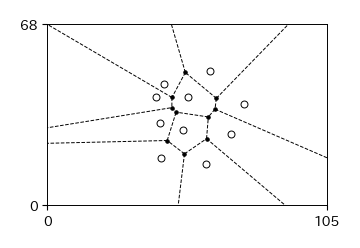

In [26]:
# トラッキングデータの読み込み
X = pd.read_csv('./7_tracking/x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./7_tracking/y_1st.csv', encoding='utf-8', index_col=0)

# 第iフレームの座標取得
i=5000
x, y = X.loc[i], Y.loc[i]
xy = np.vstack([x, y]).T

# ボロノイ領域の計算（オブジェクトの生成）
vor = Voronoi(xy)

# ボロノイ領域の描画
fig, ax = plt.subplots(figsize=(3.5, 3))
my_voronoi_plot_2d(vor, fig, ax)

# 母点の描画
ax.plot(vor.points[:, 0], vor.points[:, 1], 'ko', mfc='None')

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

## フォーメーション

サッカーにおいてフォーメーションが重要な概念であることは言うまでもない．
しかし，「フォーメーションとは何か？」と問われると，明確に答えることは意外と難しい．
おおよそ，「チーム内の選手の決まった配置」とか「選手同士の相対的位置関係のパターン」というのがフォーメーションに対する漠然としたイメージだろう．

では，こうしたフォーメーションを定量化・可視化するにはどうすればよいだろうか？
実は，これには次の２つの方法がある：
1. ある時間幅における選手の平均的な位置から割り出す
    - 3-4-3, 4-4-2などの数字の組を用いる
2. 特定の時刻における選手の隣接関係から定める
    - ドロネーネットワークを用いる
    
以下では，トラッキングデータを用いて，それぞれの方法を簡単に解説する．

### 平均フォーメーション

**絶対座標系**

まずは何も考えずに試合前半の全選手の位置をフィールド上に色分けしてプロットしてみよう．
この場合，座標原点がフィールドの左下に常に固定されているので，**絶対座標系**と呼ばれる．

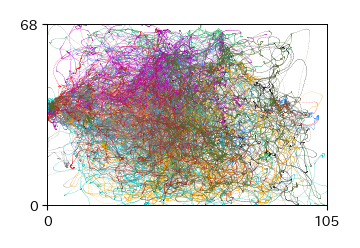

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 3))

for u in X.columns:
    ax.plot(X[u], Y[u], '.', ms=0.05)
    
ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

プロットの結果を見て明らかなように，各選手はフィールド上を縦横無尽に動き周っていることがわかる．
ポジションごとにおおよそ右サイドや中盤などの区分けはできるかもしれないが，この結果からチームのフォーメーションを推定することはできない．

**重心座標系**

次に，絶対座標系でのプロットは止めて，チームの重心を原点とする座標系に変換してみよう．
これを**重心座標系**と呼ぶ．
各選手の座標を重心座標系に変換するには，以下のように各時刻において選手の座標から重心の座標を引き算すればよい．

In [28]:
Xc = X.sub(X.mean(axis=1), axis=0)
Yc = Y.sub(Y.mean(axis=1), axis=0)

以下の２つのグラフは，いずれも重心座標系において全選手の位置を色分けしてプロットした結果である．
１つ目は選手ごとに各時刻の位置をマーカーでプロットしており，2つ目は選手ごとに平均位置と標準偏差（慣性半径）をプロットしている．

Text(0, 0.5, '$Y$')

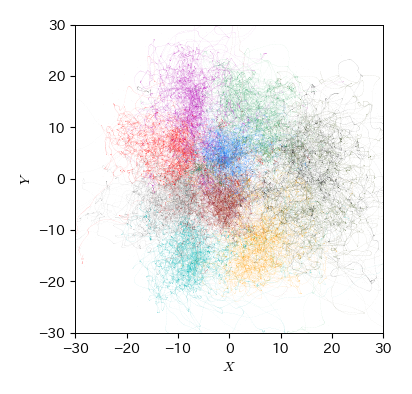

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

for u in X.columns:
    ax.plot(Xc[u], Yc[u], '.', ms=0.01)
    
ax.set_xlim(-30, 30); ax.set_ylim(-30, 30)
ax.set_aspect('equal')
ax.set_xlabel('$X$'); ax.set_ylabel('$Y$')

Text(0, 0.5, '$Y$')

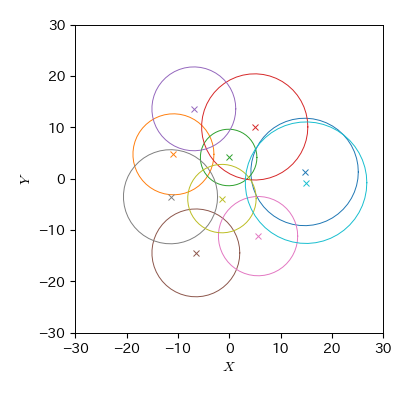

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.get_cmap("tab10") # カラーマップ
for i, u in enumerate(X.columns):
    # 平均位置
    ax.plot(Xc[u].mean(), Yc[u].mean(), 'x', ms=5, color=cmap(i))
    
    # 標準偏差（慣性半径）
    r = np.sqrt(Xc[u].var() + Yc[u].var())
    theta=np.linspace(0, 2*np.pi)
    ax.plot(Xc[u].mean()+r*np.cos(theta), Yc[u].mean()+r*np.sin(theta), '-', color=cmap(i))
    
ax.set_xlim(-30, 30); ax.set_ylim(-30, 30)
ax.set_aspect('equal')
ax.set_xlabel('$X$'); ax.set_ylabel('$Y$')

今度は選手ごとにだいたい決まった定位置（☓）を持ち，そこから標準偏差くらいの広がり（◯）を持って移動している様子が見て取れる．
特に，守備側から４人，４人，２人という並びになっており，おおよそ4-4-2というフォーメーションが見事に可視化されている．

### ドロネーネットワーク

以上は，ある程度幅のある時間帯から選手の平均位置を求めてフォーメーションを可視化する手法であった．
では，特定の時刻においてフォーメーションを定量化・可視化するにはどうすればよいだろうか？
各時刻において4-4-2や3-4-3などの数字の組を割り当てるのも一つの方法かもしれないが，実はもっと便利な方法がある．
それが以下に説明するドロネーネットワークである．

個体$p_{i}$と$p_{j}$のボロノイ領域が隣接しているときにこれらの個体同士を線で結ぶと，下のような図が作成できる．
これを**ドロネー図**あるいは**ドロネーネットワーク**と呼ぶ．
下図を見て分かるように，ドロネーネットワークは各母点を頂点とする三角形に分割できるので，**ドロネー三角形分割**と呼ぶこともある．
ドロネーネットワークは線が張られた個体間に1，その他に0を割り当てた隣接行列によって定量化される．

ドロネーネットワークは平面において隣接関係を定義する方法として知られている．
そこで，チームスポーツにおけるフォーメーションを「選手同士の隣接関係」と捉えると，ドロネーネットワークによってフォーメーションを定量化することができる．
これにより，フォーメーションの可視化や時間変化の解析など様々な応用が期待される．

In [31]:
from IPython.display import IFrame
IFrame("https://drive.google.com/file/d/1ZjMlmFO1UCsH_PfRn1Tl3qnCJDHMYoAF/preview", width=320, height=240)

### ドロネーネットワークの計算と描画

scipy.spatialにはドロネーネットワークを計算・描画するための`Delaunay`クラスと`delaunay_plot_2d`が用意されている．
まずはこれらを以下のようにインポートする．

In [32]:
from scipy.spatial import Delaunay, delaunay_plot_2d

ドロネーネットワークの計算と描画の手順はボロノイ領域と同様である：
1. ドロネーネットワークを計算したい母点の座標を取得する
2. `Delaunay`クラスを用いてオブジェクトを生成する
    ```python
    dt = Delaunay(xy)
    ```
3. `delaunay_plot_2d`関数を用いてドロネーネットワークを描画する
4. 生成したオブジェクト`dt`の様々な属性やメソッドを用いてドロネーネットワーク領域の情報を取得する

**母点の生成**

母点の座標はNumPy配列の形で第0列に$x$座標，第1列に$y$座標となるように格納する．
以下ではランダムに10個の母点を生成し`xy`という変数に読み込んでいる．

In [33]:
# 母点の生成: [[x1, y1], [x2, y2], ... ,[xn, yn]]
N = 5
xy = np.random.rand(N, 2) 

**`Delaunay`クラスによるオブジェクトの生成**

生成した母点の座標`xy`をscipy.spatialからインポートした`Delaunay`クラスに読み込んで`dt`オブジェクトを生成する．

In [34]:
# ドロネー分割の計算
dt = Delaunay(xy)

**ドロネーネットワークの描画**

scipyにはドロネーネットワークを描画する`delaunay_plot_2d`関数が用意されており，ソースコード（https://github.com/scipy/scipy/blob/v1.8.1/scipy/spatial/_plotutils.py#L36-L89 ）にアクセスできる．
ここでは，ボロノイ領域と同様に，このソースコードを少し改変した`my_delaunay_plot_2d`関数を以下のように作成し使用する．

In [35]:
def my_delaunay_plot_2d(dt, fig, ax):
    x, y = dt.points.T
    ax.triplot(x, y, dt.simplices.copy(), color='b', linestyle='-')

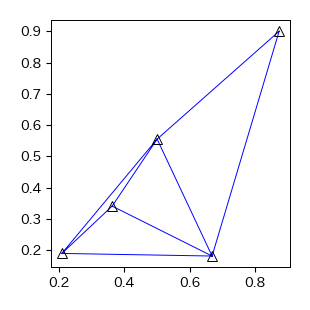

In [37]:
# プロット
fig, ax = plt.subplots(figsize=(3, 3))
my_delaunay_plot_2d(dt, fig, ax)
ax.plot(xy[:, 0], xy[:, 1], 'k^', mfc='None', ms=7)

**ドロネーネットワークの情報の取得**

In [38]:
# 母点の座標の取得
dt.points

array([[0.66830202, 0.18060487],
       [0.20873347, 0.18896438],
       [0.36269604, 0.34044331],
       [0.50020661, 0.55491989],
       [0.87339485, 0.9002502 ]])

In [39]:
# 各三角形を構成する母点のインデックス
ind_spx = dt.simplices 

# 0番目の三角形を構成する3つの母点の座標
xy[ind_spx[0]]

array([[0.50020661, 0.55491989],
       [0.66830202, 0.18060487],
       [0.87339485, 0.9002502 ]])

In [40]:
# 隣接行列の作成
A = np.zeros([N, N])
indices, indptr = dt.vertex_neighbor_vertices
for k in range(N):
    nbr = indptr[indices[k]:indices[k+1]] # k番目の母点の隣接点
    A[k][nbr] = 1
A

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0.],
       [1., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0.]])

### トラッキングデータへの応用

サッカーのトラッキングデータからドロネーネットワークを描画するには，特定のフレームにおける選手の座標を取得し，それを母点として`Delaunay`クラスのオブジェクトを生成すれば良い．

In [41]:
X = pd.read_csv('./7_tracking/x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./7_tracking/y_1st.csv', encoding='utf-8', index_col=0)

# 第iフレームの座標取得
i=2000
x, y = X.loc[i], Y.loc[i]
xy = np.vstack([x, y]).T

# ドロネーネットワークの計算
dt = Delaunay(xy)

# ボロノイ領域の計算
vor = Voronoi(xy)

以下はドロネーネットワークとボロノイ領域を同時に描画する例である．

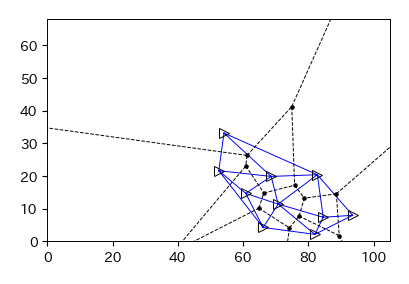

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))

# 母点
ax.plot(vor.points[:, 0], vor.points[:, 1], 'k>', mfc='None', ms=7)

# ボロノイ領域
my_voronoi_plot_2d(vor, fig, ax)

# ドロネーネットワーク
my_delaunay_plot_2d(dt, fig, ax)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_aspect('equal')

## アニメーション

最後にトラッキングデータの解析の仕上げとして，アニメーションの作成方法を紹介する．
アニメーションはMatplotlibの`FuncAnimation`を用いると簡単に実装できる．
まずは`FuncAnimation`を以下のようにインポートしておく：

In [76]:
from matplotlib.animation import FuncAnimation

アニメーションの表示には少々注意が必要である．
これまで，MatplotlibによるグラフはJupyter Lab内に表示することができた．
これは，デフォルトの設定としてグラフの出力先がJupyter Lab内となっていたからであり，明示的に設定するには以下のコマンドを実行する：

In [89]:
%matplotlib inline

一方，アニメーションを表示するには上の設定を以下のように変更する必要がある：

In [77]:
%matplotlib tk

この設定に変更しておくと，MatplotlibのグラフはJupyter Lab内ではなく別ウインドウとして表示されるはずである．
この辺りの詳細については「5. Matplotlibの基礎」の「5.6.1. 描画結果の出力先」にまとめてある．

### 位置

In [90]:
X = pd.read_csv('./7_tracking/x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./7_tracking/y_1st.csv', encoding='utf-8', index_col=0)

In [ ]:
# 描画関数
def update(i):
    #　位置座標の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)

    return [pt]

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=10)

### 位置とテキスト

In [80]:
# 描画関数
def update(i):
    #　位置座標の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)
    
    t = i*0.05
    m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
    ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
    title.set_text('$t$=%s分%s秒%s' % (m, s, ss))

    return list(np.hstack([pt, title]))

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')
title = ax.text(80, 63, '', fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=10)

### 位置・速度ベクトル・テキスト

In [81]:
# 速度ベクトルと秩序変数の計算
Vx, Vy = X.diff(20), Y.diff(20)
V = np.sqrt(Vx**2 + Vy**2)
OP = np.sqrt(np.sum(Vx/V, axis=1)**2 + np.sum(Vy/V, axis=1)**2) / 10

In [82]:
# 描画関数
def update(i):
    # 位置の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)
    
    # 速度ベクトルの更新
    vx, vy = Vx.loc[int(i)], Vy.loc[int(i)]
    aw.set_offsets(np.c_[x, y])
    aw.set_UVC(vx, vy)
    
    # テキスト
    t = i*0.05
    m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
    ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
    op = np.round(OP.loc[i], 2)
    text.set_text('$t$=%s分%s秒%s   $\phi=$%s' % (m, s, ss, op))

    return list(np.hstack([pt, aw, text]))

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')
aw = ax.quiver(np.zeros(10), np.zeros(10), np.zeros(10), np.zeros(10),\
               color='b', angles='uv', units='xy', scale=0.7, width=0.5)
text = ax.text(65, 63, '', fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=20)

### 発展問題

- チームの重心と慣性半径を描画するアニメーションを作成せよ
- チームの重心を原点とする座標系（重心座標系）でアニメーションを作成せよ